<a href="https://colab.research.google.com/github/LZHbaba/lzh_garbage_classification/blob/main/mobileNetAll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MobileNetV3Large** :

> SEED = 2022


> IMG_SIZE = 224


> loss=tf.keras.losses.CategoricalCrossentropy(
    label_smoothing=0.1
)



> patience=(10,30)


> epoch=100 




> trainable layers=last 150











In [ ]:
import numpy as np

#import tensorflow to use any tools needed for deep learning
import tensorflow as tf

#import keras api needed to implement deep learning techiques
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#import libraries for visualization of data
import matplotlib.pyplot as plt



np.random.seed(2022)
tf.random.set_seed(2022)
SEED = 2022
#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline
#paths to the train, validation and test image datasets 
train_path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'
valid_path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'

IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
# extract images to training set by applying data preprocessing and data augmentation
train_batches = ImageDataGenerator(
    preprocessing_function=  tf.keras.applications.mobilenet_v3.preprocess_input ,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=train_path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='training',seed=SEED)


# extract images to validation set
valid_batches = ImageDataGenerator(
    preprocessing_function=  tf.keras.applications.mobilenet_v3.preprocess_input ,
    validation_split=0.1).flow_from_directory(
    directory=valid_path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='validation',seed=SEED)


# import the convolution base of the VGG16 model with pre-trained weights
#base_model = tf.keras.applications.resnet.ResNet152(input_shape=IMG_SHAPE, 
                                       # include_top=False,
                                      #  weights='imagenet')
#base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
#model = Sequential()
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE, alpha=1.0, include_top=False,
    weights='imagenet', pooling=None,
    dropout_rate=0.5)
model = Sequential()
# Freeze the convolutional base of VGG16 to prevent the pre-trained weights being updated 
# during training inorder to extract features
base_model.trainable=False

# add VGG16 convolution base to initialize sequential model
model.add(base_model)

# add global average pooling layer
model.add(GlobalAveragePooling2D())

# add densely-connected NN layer with 512 hidden units
model.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(BatchNormalization())                 # normalize and scale inputs or activations
model.add(Dropout(0.5))                         # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 128 hidden units
model.add(Dense(units=128, activation='relu')) # use ReLU activation function
model.add(BatchNormalization())                # normalize and scale inputs or activations
model.add(Dropout(0.5))                        # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 6 hidden units
model.add(Dense(units=6, activation='softmax')) # use Softmax activation function to do final predictions
model.summary()
loss=tf.keras.losses.CategoricalCrossentropy(
    label_smoothing=0.1
)
loss1='categorical_crossentropy'
model.compile(optimizer=Adam(learning_rate=0.001), loss=loss, metrics=['accuracy'])



from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau

#lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.1,
                               monitor='val_loss',
                               cooldown=0,
                               patience=10,
                               min_lr=0,
                               verbose=1,
                               mode='auto',
                               
                              )
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=30)
callbacks = [lr_reducer,es]


import time
start = time.time()
history = model.fit(
   train_batches,
    steps_per_epoch=train_batches.samples/train_batches.batch_size ,
    epochs=50,
    validation_data=valid_batches,
    validation_steps=valid_batches.samples/valid_batches.batch_size,
    verbose=1,
    callbacks = callbacks)
loss = history.history['loss']
validation_loss = history.history['val_loss']
accuracy = history.history['accuracy']
validation_accuracy =history.history['val_accuracy']
from tensorflow.keras import layers
for layer in model.layers[-150:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
#base_model.trainable=True
history = model.fit(
   train_batches,
    steps_per_epoch=train_batches.samples/train_batches.batch_size ,
    epochs=50,
    validation_data=valid_batches,
    validation_steps=valid_batches.samples/valid_batches.batch_size,
    verbose=1,
    callbacks = callbacks)
loss.extend(history.history['loss'])
validation_loss.extend(history.history['val_loss'])
accuracy.extend(history.history['accuracy'])
validation_accuracy.extend(history.history['val_accuracy'])
time_used = time.time()-start
print(time_used)


epochs = range(1, len(loss)+1)

fig1 = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,'r*-',label="Training")
plt.plot(epochs,validation_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0,max(plt.ylim())])
plt.xticks(epochs)
plt.legend()

epochs1 = range(1, len(accuracy)+1)

fig2 = plt.figure(figsize=(10,6))
plt.plot(epochs1,accuracy,'r*-',label="Training")
plt.plot(epochs1,validation_accuracy,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0,max(plt.ylim())])
plt.xticks(epochs1)
plt.legend()

def save_txt(file_name='',object=[]):
    file = open(file_name, 'w')
    file.write(str(object))
    file.close()

save_txt('/content/drive/MyDrive/mobileNetV3/mobileNetV3_100_150_10_30/loss.txt',loss)
save_txt('/content/drive/MyDrive/mobileNetV3/mobileNetV3_100_150_10_30/val_loss.txt',validation_loss)
save_txt('/content/drive/MyDrive/mobileNetV3/mobileNetV3_100_150_10_30/acc.txt',accuracy)
save_txt('/content/drive/MyDrive/mobileNetV3/mobileNetV3_100_150_10_30/val_acc.txt',validation_accuracy)
save_path='/content/drive/MyDrive/mobileNetV3/mobileNetV3_100_150_10_30/mobilenetV3_parameter1_100_last150_10_30.h5'

model.save_weights(save_path)

**下载模型参数**

In [ ]:
!unzip '/content/results.zip' -d '/content/slr'

**导入模型参数**

In [ ]:
import numpy as np

#import tensorflow to use any tools needed for deep learning
import tensorflow as tf

#import keras api needed to implement deep learning techiques
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#import libraries for visualization of data
import matplotlib.pyplot as plt



np.random.seed(2022)
tf.random.set_seed(2022)
SEED = 2022
#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline
#paths to the train, validation and test image datasets 
train_path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'
valid_path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'

IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
# extract images to training set by applying data preprocessing and data augmentation
train_batches = ImageDataGenerator(
    preprocessing_function=  tf.keras.applications.mobilenet_v3.preprocess_input ,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=train_path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='training',seed=SEED)


# extract images to validation set
valid_batches = ImageDataGenerator(
    preprocessing_function=  tf.keras.applications.mobilenet_v3.preprocess_input ,
    validation_split=0.1).flow_from_directory(
    directory=valid_path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='validation',seed=SEED)


# import the convolution base of the VGG16 model with pre-trained weights
#base_model = tf.keras.applications.resnet.ResNet152(input_shape=IMG_SHAPE, 
                                       # include_top=False,
                                      #  weights='imagenet')
#base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
#model = Sequential()
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE, alpha=1.0, include_top=False,
    weights=None, pooling=None,
    dropout_rate=0.5)
model = Sequential()
# Freeze the convolutional base of VGG16 to prevent the pre-trained weights being updated 
# during training inorder to extract features
#base_model.trainable=False

# add VGG16 convolution base to initialize sequential model
model.add(base_model)

# add global average pooling layer
model.add(GlobalAveragePooling2D())

# add densely-connected NN layer with 512 hidden units
model.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(BatchNormalization())                 # normalize and scale inputs or activations
model.add(Dropout(0.5))                         # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 128 hidden units
model.add(Dense(units=128, activation='relu')) # use ReLU activation function
model.add(BatchNormalization())                # normalize and scale inputs or activations
model.add(Dropout(0.5))                        # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 6 hidden units
model.add(Dense(units=6, activation='softmax')) # use Softmax activation function to do final predictions
model.summary()
loss=loss=tf.keras.losses.CategoricalCrossentropy(
    label_smoothing=0.1
)
loss1='categorical_crossentropy'
model.compile(optimizer=Adam(learning_rate=0.001), loss=loss, metrics=['accuracy'])
model.load_weights('/content/mobilenetV3_parameter1_100_last150_10_30.h5')
model.summary()

In [ ]:
valid_datagen = ImageDataGenerator(
    preprocessing_function=  tf.keras.applications.mobilenet_v3.preprocess_input ,
    validation_split=0.1)
valid_batches=valid_datagen.flow_from_directory(
    directory=valid_path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='validation',seed=SEED)

Found 251 images belonging to 6 classes.


**evaluate model**

In [ ]:
loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
loss1='categorical_crossentropy'
model.compile(optimizer=Adam(learning_rate=0.001), loss=loss1, metrics=['accuracy'])

In [ ]:
model.evaluate(valid_batches)

16/16 [==============================] - 63s 3s/step - loss: 0.2165 - accuracy: 0.9203


[0.21645504236221313, 0.9203187227249146]

**evaluate every category**

In [ ]:
from keras.preprocessing import image
calculate_acc=np.zeros([2,6])
label_acc=np.zeros([3,10])
num=0
for i in range(15):
  img_all,label_all= valid_batches[i]
  #print(img_all.shape)
  #print(label_all.shape)
#print(label_all)
  label=np.argmax(label_all,axis=1)
  
#print(label)
  prediction=model.predict(img_all)
  #print(prediction.shape) 
  predict_label_dig=np.argmax(prediction,axis=-1)
  for j in range(15):  
    #predict_label_dig
    calculate_acc[0,label[j]]=calculate_acc[0,label[j]]+1
    if predict_label_dig[j] == label[j]:
      calculate_acc[1,predict_label_dig[j]]=calculate_acc[1,predict_label_dig[j]]+1
    if label[j]==5:
      #print(predict_label_dig[j])
      if predict_label_dig[j] != label[j]:
        print(predict_label_dig[j])
        plt.figure(num)
        img=np.array(img_all[j,:,:,:])/225
        plt.imshow(img.squeeze())
        num=num+1
   


calculate_acc 
evaluate_result=calculate_acc[1,:]/calculate_acc[0,:]
evaluate_result 
#3，10，13，20，21，26，28

**predict test set image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Maximum Probability:  0.9997038
Classified: trash


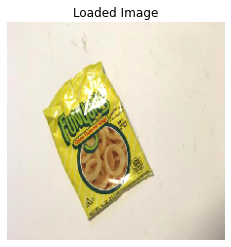

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import urllib.request
img_path = '/content/drive/MyDrive/datasets_garbage/Garbage classification/trash/trash109.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
p=model.predict(img[np.newaxis, ...])

plt.title("Loaded Image")
plt.axis('off')
image=np.array(img)/225
plt.imshow(image.squeeze())

#p=model2.predict(img[np.newaxis, ...])
#print(p)
#print("Predicted shape",p.shape)
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)



**draw bar of input url**

In [ ]:
classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

    
def plot_bar_x(imagePath):
    import numpy as np
    import urllib.request
    from keras.preprocessing import image as ig
    savepath='/content/drive/MyDrive/outside_url/picture.jpg'
    urllib.request.urlretrieve(imagePath,savepath)
    #image = Image.open(savepath)
    test_image=ig.load_img(savepath,target_size=(224, 224))
    test_image=ig.img_to_array(test_image)
    test_image=np.expand_dims(test_image,axis=0)
    result=model.predict(test_image,verbose=0)
    classes=[]
    prob=[]
    labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    for i,j in enumerate (result[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')#向上取整保留两位小数
        classes.append(labels[i])
        prob.append(round(j*100,2))#将概率和分类都append到list中
        # this is for plotting purpose
    index = np.arange(len(classes))#【0，1，2，3，4，5】
    plt.bar(index, prob)#画出bar
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)#标下标，旋转20°
    plt.title('Probability for loaded image')
    plt.show()


#plot_bar_x()
imagePath='/content/drive/MyDrive/datasets_garbage/Garbage classification/trash/trash102.jpg'
plot_bar_x(imagePath)

**Connect to the anvil**

In [ ]:
import urllib.request
from PIL import Image
from keras.preprocessing import image as ig
!pip install anvil-uplink
import anvil.server
from tensorflow.keras.preprocessing.image import ImageDataGenerator
path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'
anvil.server.connect("MO5GXYH2BNZVQAPL5G4GOBYI-EEGR56LYS6J5GIZN")
train_batches = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.efficientnet.preprocess_input ,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=path, target_size=(224,224), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='training')
TrainImageClasses = train_batches.class_indices
print(TrainImageClasses)
table = {}
for imageVal, imageName in zip(TrainImageClasses.values(), TrainImageClasses.keys()):
    table[imageVal] = imageName

@anvil.server.callable
def predict_external_image(imagePath):
    import numpy as np
    savepath='/content/drive/MyDrive/outside_url/picture.jpg'
    urllib.request.urlretrieve(imagePath,savepath)
    #image = Image.open(savepath)
    test_image=ig.load_img(savepath,target_size=(224, 224))
    test_image=ig.img_to_array(test_image)
    test_image=np.expand_dims(test_image,axis=0)
    result=model.predict(test_image,verbose=0)
    labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    predicted_class = table[np.argmax(result)]
    #example_image = transformations(image)
    image1=np.array(test_image)/225
    plt.imshow(image1.squeeze())
    print("The image resembles", predicted_class + ".")
    return predicted_class


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles metal.


'metal'

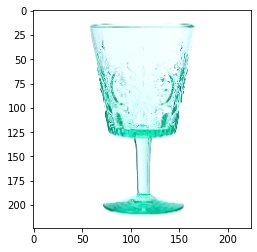

In [ ]:
imagePath='https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse3.mm.bing.net%2Fth%3Fid%3DOIP.G37FJ-GhP9SrFxc8Msx16gHaHa%26pid%3DApi&f=1'
#savepath='/content/drive/MyDrive/outside_url/picture.jpg'
#urllib.request.urlretrieve(imagePath,savepath)
predict_external_image(imagePath)

**Draw confusion matrix**

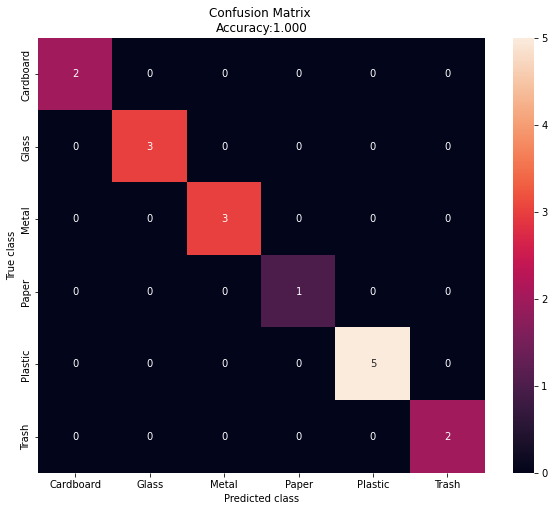

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

cm = confusion_matrix(label, predict_label_dig) #
LABELS=['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']
cm_df = pd.DataFrame(cm,index = LABELS, columns = LABELS)

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix \nAccuracy:{0:.3f}'.format(accuracy_score(label, predict_label_dig)))
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()